In [101]:
# nltk.download('stopwords')

In [102]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [103]:
# Gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, Phrases
from gensim.models.phrases import Phraser
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [104]:
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
from nltk.corpus import stopwords
from nltk import Tree

stop_words = stopwords.words('english')

In [106]:
df = pd.read_csv("usnewspaper_china.csv", header=None,)

In [107]:
data = df[0].dropna().tolist()

In [108]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
/var/folders/fd/qmhdtpdj7kj77ftrqfj87hmc0000gn/T/ipykernel_3918/2869499433.py:2: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [109]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    
data_words = list(sent_to_words(data))

In [110]:
# Define functions for stopwords and lemmatization
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [111]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [112]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm')

In [113]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [114]:
data_lemmatized[2][:10]

['image',
 'make',
 'video',
 'chinese',
 'spokesperson',
 'gesture',
 'speak',
 'medium',
 'affair']

## Bigrams and Trigrams

In [115]:
bigram = Phrases(data_lemmatized, min_count=20, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [140]:
data_with_phrases = [trigram_mod[bigram_mod[doc]] for doc in data_lemmatized]

In [141]:
data_with_phrases[1][:10]

['cookie',
 'small_piece',
 'datum',
 'text_file',
 'website',
 'visit',
 'user',
 'ask',
 'browser',
 'store']

In [153]:
# Create Dictionary
id2word = corpora.Dictionary(data_with_phrases)
id2word.filter_extremes(no_above=0.5) # brings down unique tokens from 80 thousand to 12

# Create Corpus
texts = data_with_phrases#data_with_phrases

# Term Frequency list   
corpus = [id2word.doc2bow(text) for text in texts] 

In [154]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                id2word=id2word,
                num_topics=25, 
                random_state=100,
                update_every=1,
                chunksize=2000,
                passes=10,
                alpha='auto',
                eta='auto',
                per_word_topics=True)

In [155]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 16288
Number of documents: 10000


In [156]:
# Check the type of the numbers in the LDA topics
for topic in lda_model.print_topics():
    for word, prob in lda_model.show_topic(topic[0]):
        if isinstance(prob, complex):
            print(f"Complex number found in topic {topic[0]} for word '{word}'")

In [157]:
# Print the Keyword
#print(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [158]:
lda_model.print_topics()

[(17,
  '0.072*"que" + 0.031*"por" + 0.023*"estado_unido" + 0.017*"segun" + 0.016*"paise" + 0.015*"estadounidense" + 0.014*"este" + 0.009*"unido" + 0.009*"para" + 0.008*"pero"'),
 (21,
  '0.047*"use" + 0.043*"tiktok" + 0.039*"cookie" + 0.035*"website" + 0.022*"sale" + 0.019*"site" + 0.019*"device" + 0.013*"datum" + 0.013*"include" + 0.013*"set"'),
 (18,
  '0.096*"apple" + 0.044*"iphone" + 0.019*"sale" + 0.012*"smartphone" + 0.012*"first" + 0.010*"last" + 0.010*"quarter" + 0.010*"report" + 0.009*"expect" + 0.008*"demand"'),
 (7,
  '0.042*"philippine" + 0.021*"claim" + 0.018*"vessel" + 0.016*"dispute" + 0.013*"water" + 0.013*"ship" + 0.011*"force" + 0.008*"territorial" + 0.008*"maritime" + 0.007*"take"'),
 (24,
  '0.036*"space" + 0.016*"satellite" + 0.015*"mission" + 0.014*"flight" + 0.013*"first" + 0.011*"launch" + 0.010*"moon" + 0.007*"land" + 0.007*"rocket" + 0.007*"new"'),
 (11,
  '0.020*"new" + 0.014*"researcher" + 0.012*"study" + 0.011*"car" + 0.010*"datum" + 0.008*"animal" + 0.008

In [159]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [160]:
try:
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
except Exception as e:
    print(f"Error preparing LDA visualization: {e}")

In [161]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.123472 -0.007948       1        1  12.609381
23    -0.071081 -0.054689       2        1  11.989681
13    -0.040787 -0.047166       3        1   8.020954
6      0.027410 -0.204294       4        1   7.819175
15    -0.105133  0.030558       5        1   6.961857
12     0.019247 -0.167533       6        1   5.552617
14    -0.035954 -0.031132       7        1   4.712799
0     -0.109751  0.103908       8        1   4.374678
2     -0.112352  0.054482       9        1   3.702266
8     -0.029311 -0.116215      10        1   3.687408
1     -0.047587  0.066383      11        1   3.342639
5      0.011043 -0.008639      12        1   3.110828
16     0.152000 -0.175176      13        1   2.606037
3     -0.126775  0.146592      14        1   2.582928
4     -0.093655  0.073534      15        1   2.481713
22    -0.023015 -0.016465      16        1   2.456679
20     0.109791 -0.173685      17        1   2.359202
7     -0.099423  0.144555      18        1   1.952554
19    -0.055958  0.127716      19        1   1.936372
11     0.018302 -0.001722      20        1   1.797857
10    -0.003868 -0.028276      21        1   1.700832
24    -0.025589  0.021592      22        1   1.421254
17     0.404418  0.217987      23        1   1.199228
21     0.248331  0.155055      24        1   0.830656
18     0.113169 -0.109420      25        1   0.790406, topic_info=          Term         Freq        Total Category  logprob  loglift
2193   balloon  4253.000000  4253.000000  Default  30.0000  30.0000
211   military  8871.000000  8871.000000  Default  29.0000  29.0000
1235   company  8816.000000  8816.000000  Default  28.0000  28.0000
344        use  8338.000000  8338.000000  Default  27.0000  27.0000
285      share  4124.000000  4124.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
651      price    86.712221  3135.298769  Topic25  -5.2815   1.2525
792     launch    79.482406  1721.635309  Topic25  -5.3686   1.7649
611        end    85.296191  3128.011502  Topic25  -5.2980   1.2384
624      group    81.370830  2962.439975  Topic25  -5.3451   1.2456
124       fall    79.079377  2347.037996  Topic25  -5.3736   1.4499

[1872 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
8045     20  0.972059  able_replicate
2982      2  0.980825        abortion
2982      8  0.011539        abortion
1089      1  0.135855          access
1089      2  0.016982          access
...     ...       ...             ...
1224     21  0.051480            zone
1224     24  0.006178            zone
8868     19  0.996517             zoo
5044     20  0.986765          zookey
7787     17  0.991809              zu

[8206 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 24, 14, 7, 16, 13, 15, 1, 3, 9, 2, 6, 17, 4, 5, 23, 21, 8, 20, 12, 11, 25, 18, 22, 19])

In [162]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -7.725564537554809


In [165]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_with_phrases, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5239605663982185


## Testing different number of topics for LDA

In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = LdaModel(corpus=corpus,
                id2word=id2word,
                num_topics=num_topics, 
                random_state=100,
                update_every=1,
                chunksize=2000,
                passes=10,
                alpha='auto',
                eta='auto'
                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=18, limit=27, step=2)

18
20
22
24
26


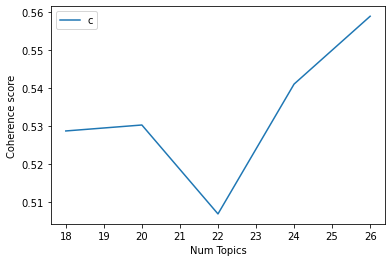

In [31]:
limit=27; start=18; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 18  has Coherence Value of 0.5287
Num Topics = 20  has Coherence Value of 0.5303
Num Topics = 22  has Coherence Value of 0.5069
Num Topics = 24  has Coherence Value of 0.5411
Num Topics = 26  has Coherence Value of 0.559


### The optimal number of topics was 25

In [33]:
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))